In [ ]:
library(tree)
library(randomForest)
library(FNN)
library(caret)
library(adabag) 
library(gbm) 
library(MASS)
library(xgboost)
library(gRain)
library(bnlearn)

#### Preparar datos

In [3]:
data = read.csv("dfML.csv")
dfML = data[, -1]; rm(data)

In [4]:
dfML$Product_Form <- factor(dfML$Product_Form)

In [5]:
y <- dfML$DT41J_Celsius
x <- dfML[,-7]

In [6]:
set.seed(2)
n <- length(y)
ind.train <- sample(1:n, round(0.85*n))
ind.test <- setdiff(1:n,ind.train)

In [7]:
params.scaling <- preProcess(x[ind.train,-1], method = c("center", "scale"))
x[ind.train,-1] <- scale(x[ind.train,-1], center = params.scaling$mean, scale = params.scaling$std)
x[ind.test,-1] <- scale(x[ind.test,-1], center = params.scaling$mean, scale = params.scaling$std)

In [8]:
dfscale <- data.frame(y, x)
y.train <- y[ind.train]
y.test <- y[ind.test]
x.train <- x[ind.train,]
x.test <- x[ind.test,]

In [9]:
rmse <- function(x, y) {
    stopifnot(length(x) == length(y))
    sqrt(mean((x - y)^2))
}

In [10]:
#con one hot encoding para PF
#cambiar product form a one hot encoding
col <- dfscale$Product_Form
positions <- which(col == 'SRM')
col[positions] <- 'P'
dfProdForm <- model.matrix(~ col - 1)[,-3]

In [11]:
#con integer encoding para PF
xaux <- x

In [12]:
xaux$Product_Form <- as.numeric(xaux$Product_Form)
xaux$Product_Form[which(xaux$Product_Form == 3)] <- 2
xaux$Product_Form[which(xaux$Product_Form == 4)] <- 3

#### Árboles de regresión

In [150]:
tree.completo = tree(y ~., data=dfscale, subset = ind.train, mincut = 1, minsize = 2, mindev = 0)

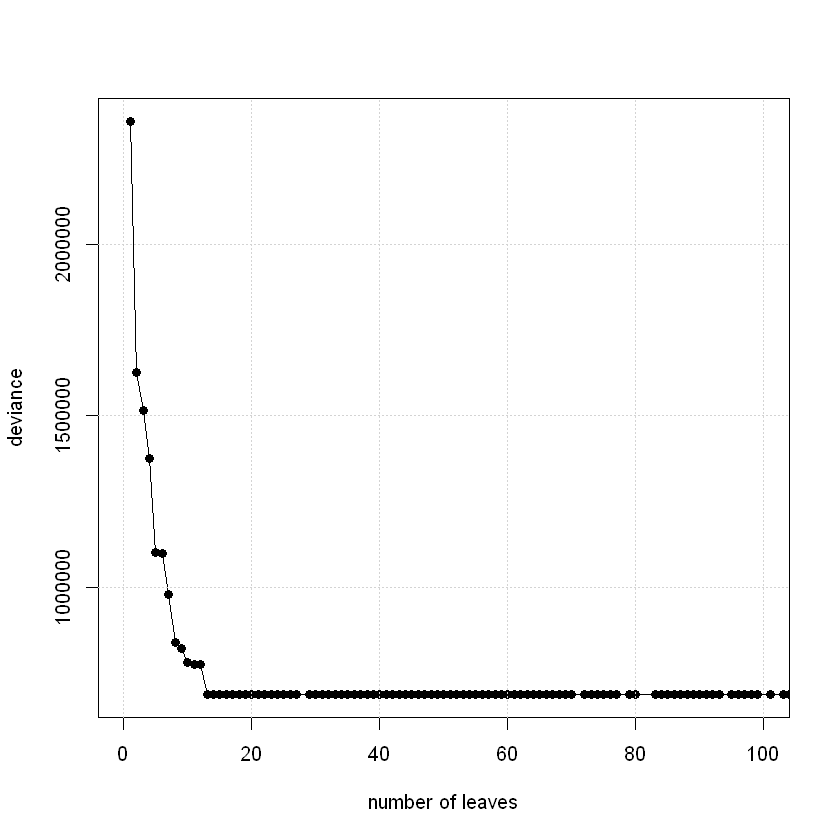

In [151]:
set.seed(1)
tree.cv = cv.tree(tree.completo, K = 20)  
plot(tree.cv$size, tree.cv$dev,
     type = "o", pch = 19,
     xlab = "number of leaves", ylab = "deviance",
     xlim = c(0,100))
grid()

In [152]:
tree.optimo <- prune.tree(tree.completo, best=18)

In [153]:
DT.pred.tree <- predict(tree.optimo, dfscale[ind.test,])

In [154]:
rmse(y.test,DT.pred.tree)

[1] 18.28047

#### KNN regresión

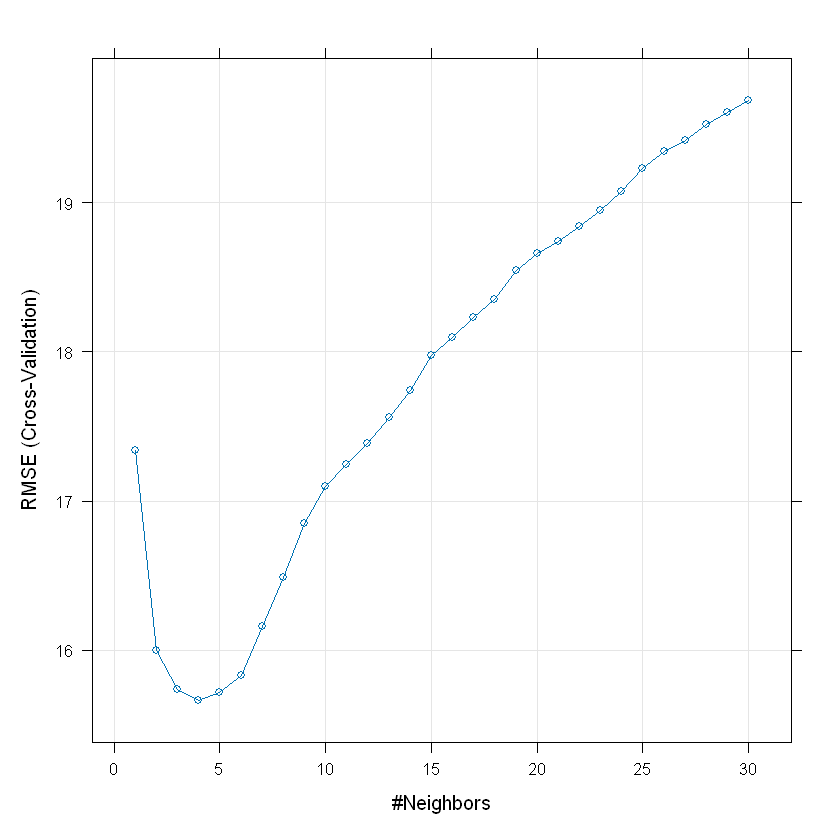

In [123]:
set.seed(1)
trctrl = trainControl(method = "cv", number = 20)
knn.optimo = train(y ~ ., dfscale, subset = ind.train,
                method = "knn",
                trControl = trctrl,
                preProcess = c("center", "scale"),
                tuneGrid = expand.grid(k = seq(1, 30, 1)))
plot(knn.optimo)

In [124]:
knn.opt <- knn.reg(train = x.train[,-1], test = x.test[,-1], 
             y = y.train, k = 4)
DT.pred.knn <- knn.opt$pred

In [125]:
rmse(y.test,DT.pred.knn)

[1] 14.85234

In [127]:
knn.opt2 <- knn.reg(train = data.frame(dfProdForm,x[,-1])[ind.train,], 
                   test = data.frame(dfProdForm,x[,-1])[ind.test,], y = y.train, k = 4)
DT.pred.knn2 <- knn.opt2$pred

In [128]:
rmse(y.test,DT.pred.knn2)

[1] 14.85101

In [131]:
knn.opt3 <- knn.reg(train = xaux[ind.train,], 
                   test = xaux[ind.test,], y = y.train, k = 4)
DT.pred.knn3 <- knn.opt3$pred

In [132]:
rmse(y.test,DT.pred.knn3)

[1] 14.7101

#### Random forest

In [11]:
set.seed(1)
rf = randomForest(y ~., dfscale , subset = ind.train)

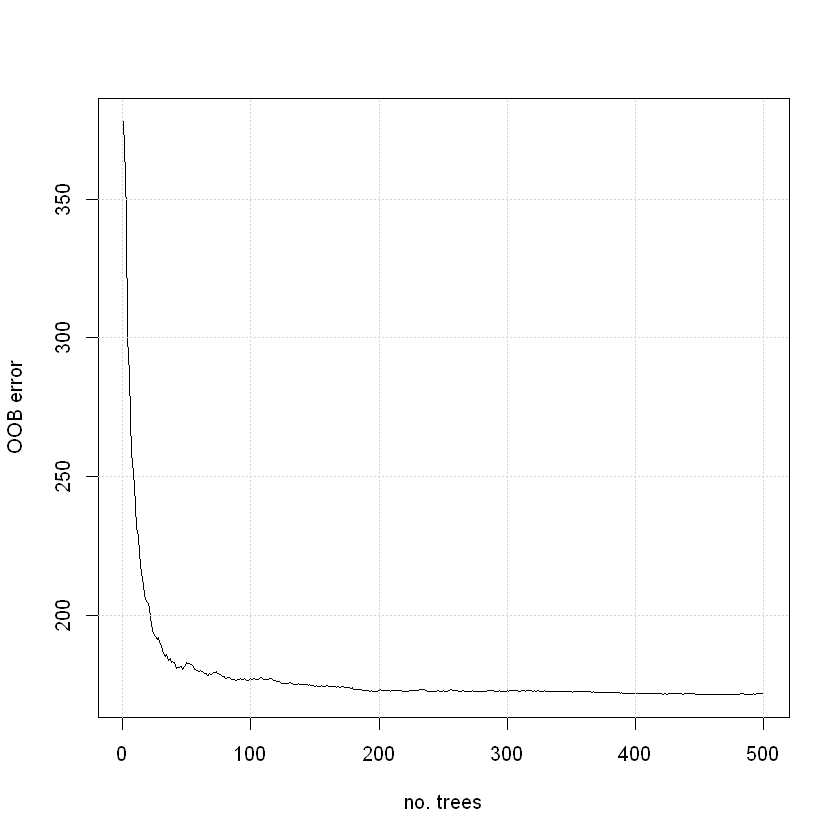

In [12]:
plot(rf$mse, type = "l", xlab = "no. trees",
ylab = "OOB error"); grid()

In [13]:
ntreeval <- 200
mtryval <- length(x[1,])/3
set.seed(1)
rf.optimo <- randomForest(y ~ .,  dfscale, subset = ind.train, ntree = ntreeval, mtry = mtryval)

In [14]:
DT.pred.rf <- predict(rf.optimo, dfscale[ind.test, ])

In [15]:
rmse(DT.pred.rf,y.test)

[1] 12.15464

#### Gradient boosting

In [36]:
#gbm CV solo  n.trees
set.seed(1)

gb.cv <- gbm(y~., data=dfscale[ind.train, ], n.trees=5000, 
             interaction.depth=20, shrinkage = 0.01, cv.folds = 10)

Distribution not specified, assuming gaussian ...


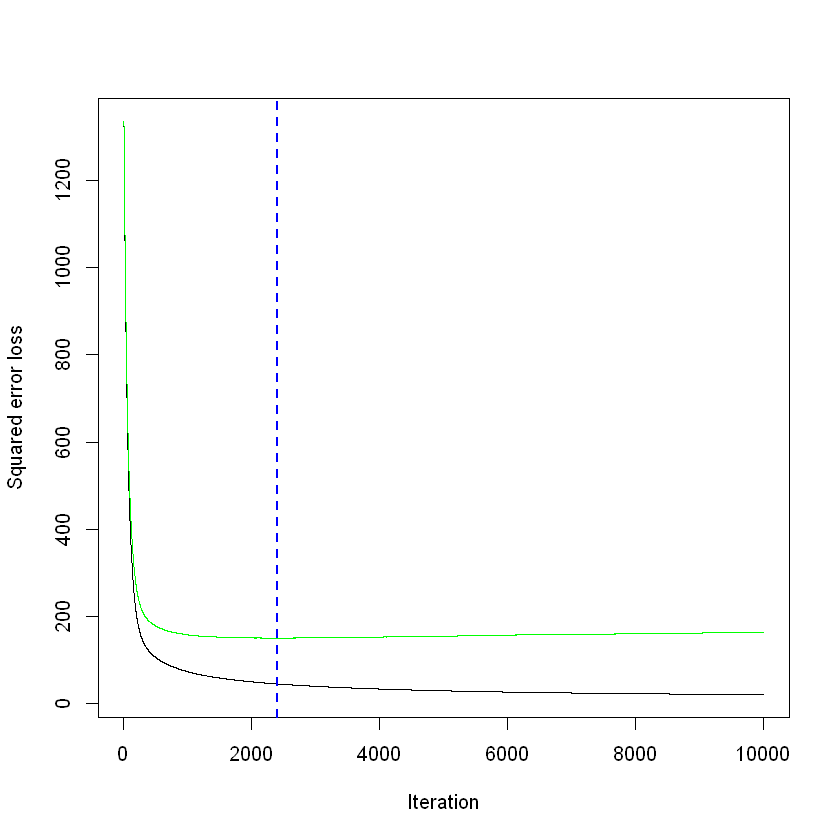

In [37]:
set.seed(1)
ntree_opt_cv <- gbm.perf(gb.cv, method = "cv")

In [23]:
set.seed(1)
gb <- gbm(y~., data=dfscale[ind.train, ], n.trees=ntree_opt_cv, 
          interaction.depth=20, shrinkage = 0.01)

Distribution not specified, assuming gaussian ...


In [24]:
DT.pred.gbm <- predict(object = gb, newdata = dfscale[ind.test, ], 
                        n.trees = ntree_opt_cv, type = "response")

In [25]:
rmse(DT.pred.gbm,y.test)

[1] 11.34054

Distribution not specified, assuming gaussian ...
Distribution not specified, assuming gaussian ...
Distribution not specified, assuming gaussian ...


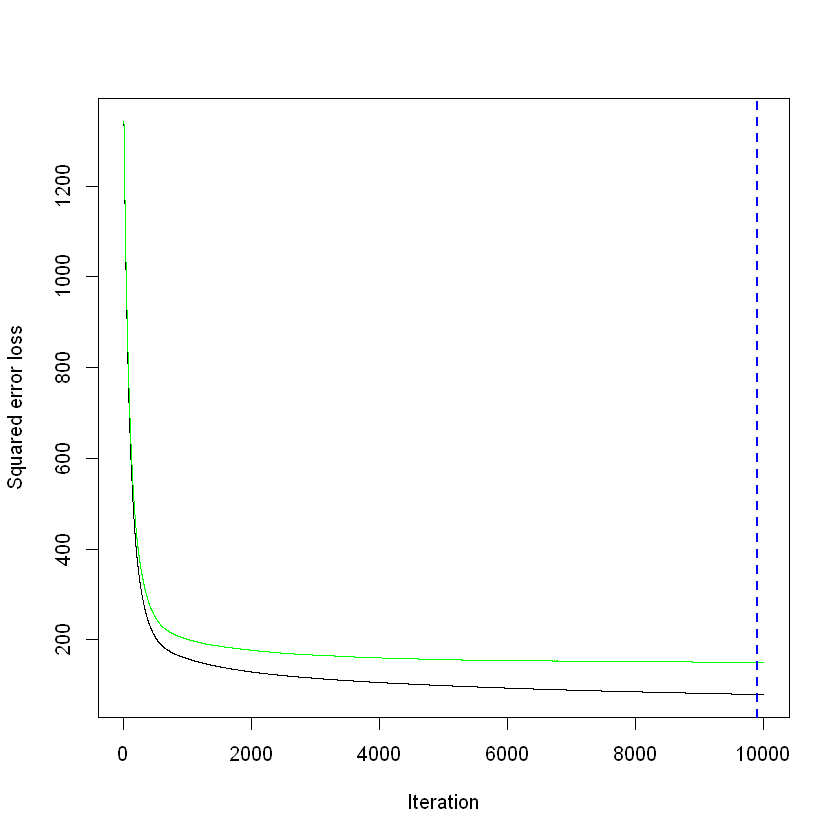

Distribution not specified, assuming gaussian ...
Distribution not specified, assuming gaussian ...


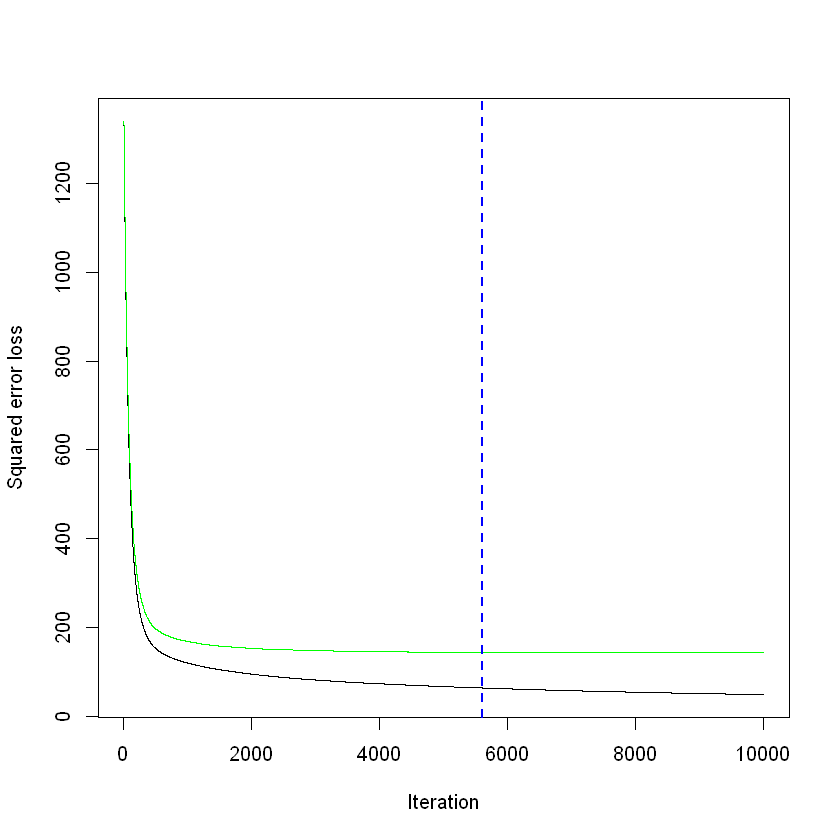

Distribution not specified, assuming gaussian ...


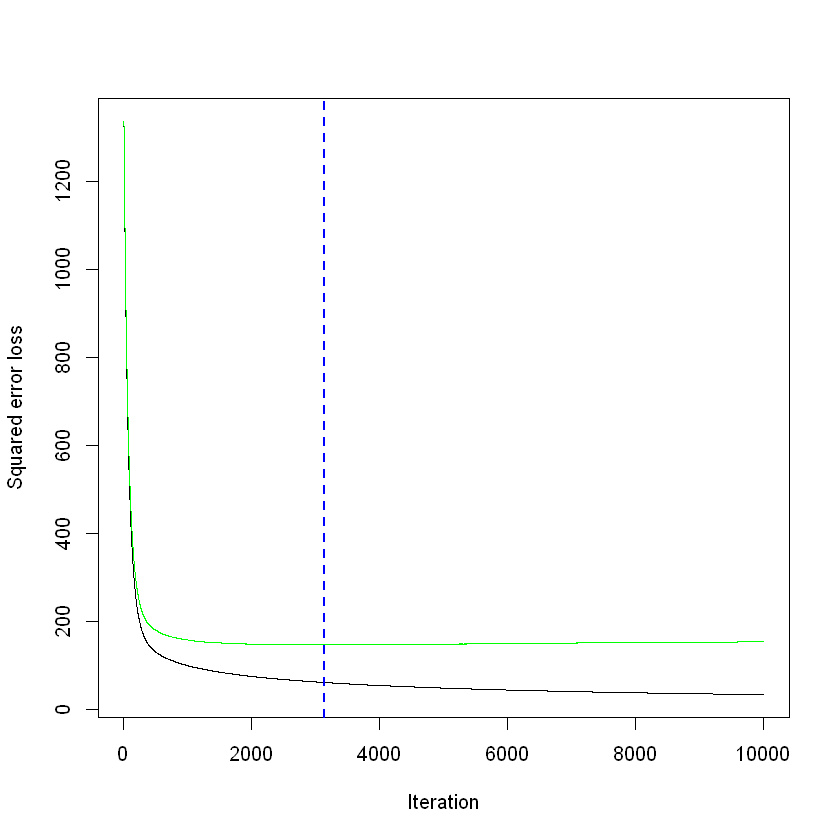

In [49]:
#gbm CV n.trees y depth
set.seed(1)
depth_range <- c(3,6,10)

min_error <- 100
param_opt <- list(
    ntree_opt = 0,
    depth_opt = 0
)

for (d in depth_range){
    gb.cv <- gbm(y~., data=dfscale[ind.train, ], n.trees=10000, 
                 interaction.depth=d, shrinkage = 0.01, cv.folds = 10)
    ntree_opt_cv <- gbm.perf(gb.cv, method = "cv")
    gb <- gbm(y~., data=dfscale[ind.train, ], n.trees=ntree_opt_cv, 
              interaction.depth=d, shrinkage = 0.01)
    DT.pred.gbm <- predict(object = gb, newdata = dfscale[ind.test, ], 
                            n.trees = ntree_opt_cv, type = "response")
    error <-rmse(DT.pred.gbm,y.test)
    if (error < min_error){
        min_error <- error
        param_opt$ntree_opt <- ntree_opt_cv
        param_opt$depth_opt <- d
    }
} 

In [50]:
print(min_error)
print(param_opt)

[1] 10.98208
$ntree_opt
[1] 5596

$depth_opt
[1] 6



In [18]:
#xgboost
#cv de eta max_depth 
nroundsmax <- 300
nthreadval <- 2

eta_range <- c(0.1,0.3,0.5,1)
depth_range <- c(3,6,12)

param <- expand.grid(eta_range,depth_range)
param_opt <- list(
    eta_opt = 0,
    depth_opt = 0
)
best_error <- 100
xboost.cv <- 0

for (icomb in 1:dim(param)[1]){
    xboost.cv.iter <- xgb.cv(data = as.matrix(xaux[ind.train,]), label = dfscale$y[ind.train],
                             nrounds = nroundsmax, nthread = nthreadval, nfold = 10, metrics = list("rmse"),
                             max_depth = param$Var2[i], eta = param$Var1[i], objective = "reg:squarederror",
                             verbose = FALSE)
    min_error <- min(xboost.cv.iter$evaluation_log$test_rmse_mean)
    if (min_error<best_error){
        best_error <- min_error
        xboost.cv <- xboost.cv.iter
        param_opt$eta_opt <- param$Var1[i]
        param_opt$depth_opt <- param$Var2[i]
    }     
}

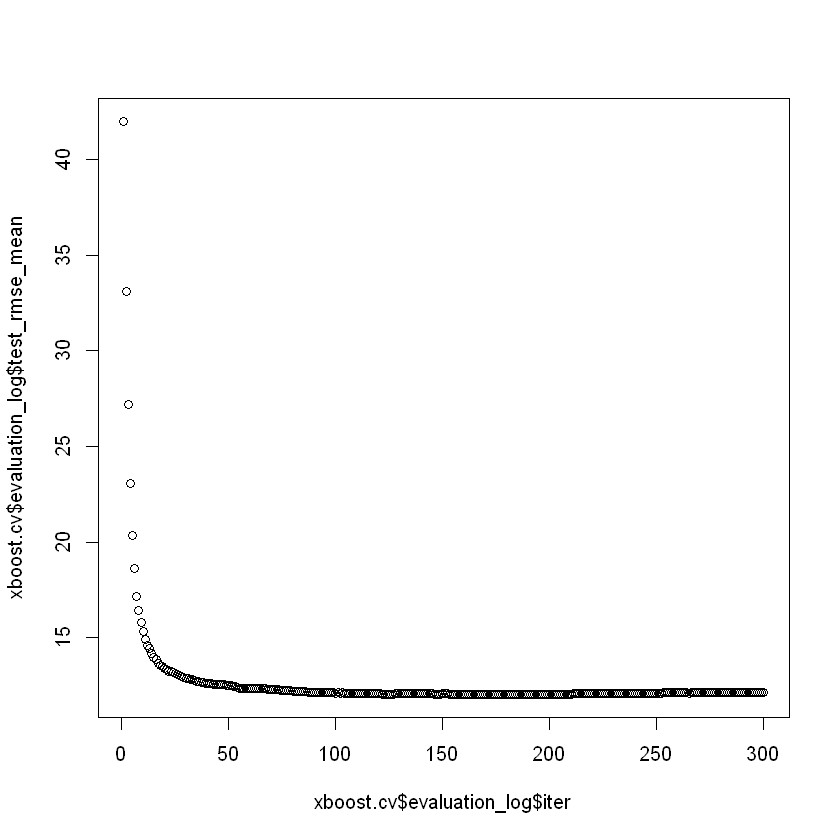

In [19]:
plot(xboost.cv$evaluation_log$iter,xboost.cv$evaluation_log$test_rmse_mean)

In [20]:
param_opt

$eta_opt
[1] 0.3

$depth_opt
[1] 3

In [21]:
#cv de nrounds
etaval <- 0.3
max_depthval <- 3
nroundsopt <- 100

In [22]:
set.seed(1)
xboost <- xgboost(data = as.matrix(xaux[ind.train,]), label = dfscale$y[ind.train],max.depth = max_depthval, 
                  eta = etaval, nrounds = nroundsopt, nthread = nthreadval,verbose = FALSE)

In [23]:
DT.pred.xgb <- predict(xboost, newdata = as.matrix(xaux[ind.test, ]), type = "response")

In [24]:
rmse(y.test,DT.pred.xgb)

[1] 12.00163

#### 

In [ ]:
#otras metricas
# print(paste0("rmseOpt: ",rmse(y.test,pred.opt$pred)))
# print(paste0("spearmanOpt: ",cor(y.test,pred.opt$pred,method="spearman")))
# print(paste0("ration.varOpt: ",var(pred.opt$pred)/var(y.test)))